In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries

In [9]:
# Configuration
CONFIG = {
    "alpha_vantage": {
        "key": "OSTGMWJT2YTR8SKP",
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.8,
    },
    "plots": {
        "xticks_interval": 90,
        "colors": {
            "actual": "#001f3f",
            "train": "#3D9970",
            "val": "#0074D9",
            "pred_train": "#3D9970",
            "pred_val": "#0074D9",
            "pred_test": "#FF4136",
        },
    },
    "model": {
        "input_size": 1,
        "lstm_size": 32,
        "num_lstm_layers": 2,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epochs": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },
}

In [15]:
# Utility Functions
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    dates = list(reversed(list(data.keys())))
    prices = np.array([float(data[date]["4. close"]) for date in dates])

    num_data_points = len(dates)
    display_date_range = f"from {dates[0]} to {dates[-1]}"
    print(f"Number of data points: {num_data_points}, {display_date_range}")

    return dates, prices

def plot_prices(dates, prices, title, color):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, prices, color=color)
    plt.xticks(range(0, len(dates), CONFIG["plots"]["xticks_interval"]), rotation=90)
    plt.title(title)
    plt.grid(axis="y", linestyle="--")
    plt.show()

In [11]:
class Normalizer:
    def fit_transform(self, x):
        self.mu, self.sd = x.mean(), x.std()
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return x * self.sd + self.mu

def create_dataset(prices, window_size):
    x = np.lib.stride_tricks.sliding_window_view(prices, window_size)[:-1]
    y = prices[window_size:]
    return x, y

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x[..., None].astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, lstm_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(lstm_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


In [12]:

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for x, y in dataloaders[phase]:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(x).squeeze()
                    loss = criterion(outputs, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f}")
        scheduler.step()


Number of data points: 6320, from 1999-11-01 to 2024-12-12


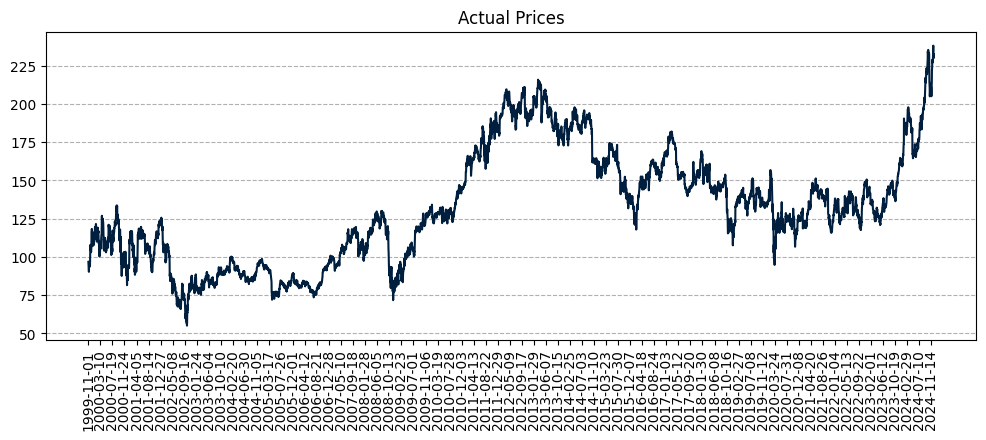

train Loss: 0.0893
val Loss: 0.0136
train Loss: 0.0090
val Loss: 0.0115
train Loss: 0.0081
val Loss: 0.0090
train Loss: 0.0077
val Loss: 0.0096
train Loss: 0.0068
val Loss: 0.0088
train Loss: 0.0066
val Loss: 0.0085
train Loss: 0.0063
val Loss: 0.0076
train Loss: 0.0065
val Loss: 0.0082
train Loss: 0.0064
val Loss: 0.0072
train Loss: 0.0060
val Loss: 0.0091
train Loss: 0.0053
val Loss: 0.0070
train Loss: 0.0053
val Loss: 0.0095
train Loss: 0.0053
val Loss: 0.0102
train Loss: 0.0057
val Loss: 0.0074
train Loss: 0.0052
val Loss: 0.0063
train Loss: 0.0049
val Loss: 0.0078
train Loss: 0.0049
val Loss: 0.0077
train Loss: 0.0052
val Loss: 0.0069
train Loss: 0.0047
val Loss: 0.0063
train Loss: 0.0049
val Loss: 0.0080
train Loss: 0.0048
val Loss: 0.0072
train Loss: 0.0045
val Loss: 0.0071
train Loss: 0.0048
val Loss: 0.0072
train Loss: 0.0049
val Loss: 0.0057
train Loss: 0.0049
val Loss: 0.0073
train Loss: 0.0046
val Loss: 0.0094
train Loss: 0.0050
val Loss: 0.0074
train Loss: 0.0044
val Loss:

In [16]:
# Main Workflow
data_dates, data_prices = download_data(CONFIG)
plot_prices(data_dates, data_prices, "Actual Prices", CONFIG["plots"]["colors"]["actual"])

scaler = Normalizer()
norm_prices = scaler.fit_transform(data_prices)

x, y = create_dataset(norm_prices, CONFIG["data"]["window_size"])
split_idx = int(len(y) * CONFIG["data"]["train_split_size"])

data = {
    "train": TimeSeriesDataset(x[:split_idx], y[:split_idx]),
    "val": TimeSeriesDataset(x[split_idx:], y[split_idx:]),
}

dataloaders = {
    phase: DataLoader(data[phase], batch_size=CONFIG["training"]["batch_size"], shuffle=(phase == "train"))
    for phase in ["train", "val"]
}

model = LSTMModel(
    input_size=CONFIG["model"]["input_size"],
    lstm_size=CONFIG["model"]["lstm_size"],
    num_layers=CONFIG["model"]["num_lstm_layers"],
    dropout=CONFIG["model"]["dropout"],
).to(CONFIG["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["training"]["learning_rate"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG["training"]["scheduler_step_size"], gamma=0.1)

train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    CONFIG["training"]["num_epochs"],
    CONFIG["training"]["device"],
)